In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import xarray as xr
from jax import random
from jaxtyping import Array, Float32, Int32, UInt32
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from pydantic import BaseModel, ConfigDict
from tqdm.notebook import tqdm
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
class ModelData(BaseModel):
    counts: Float32[Array, "_ n_series"]
    available: Float32[Array, "_ n_series"]
    t: Int32[Array, "_"]  # noqa: F821
    model_config = ConfigDict(arbitrary_types_allowed=True)

In [4]:
def generate_intermediate_counts(
    rng_key: UInt32[Array, "2"],
    n_series: int,
    t_max: int,
    a: float = 1.0,
    p: float = 0.5,
) -> ModelData:
    rng_key, rng_subkey = random.split(rng_key)
    lambdas = random.gamma(rng_subkey, a=a, shape=(1, n_series))

    rng_key, rng_subkey = random.split(rng_key)
    counts = random.poisson(rng_subkey, lam=lambdas, shape=(t_max, n_series))
    counts = counts.astype(jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    available = random.bernoulli(rng_subkey, p=p, shape=counts.shape).astype(
        jnp.float32
    )
    counts = available * counts

    t = jnp.arange(counts.shape[0])
    return ModelData(counts=counts, available=available, t=t)


def train_dest_split(
    model_data: ModelData, t_max_train: int
) -> tuple[ModelData, ModelData]:
    counts_train = model_data.counts[:t_max_train, :]
    counts_test = model_data.counts[t_max_train:, :]

    available_train = model_data.available[:t_max_train, :]
    available_test = model_data.available[t_max_train:, :]

    t_train = jnp.arange(counts_train.shape[0])
    t_test = jnp.arange(
        counts_train.shape[0], counts_train.shape[0] + counts_test.shape[0]
    )

    model_data_train = ModelData(
        counts=counts_train, available=available_train, t=t_train
    )
    model_data_test = ModelData(counts=counts_test, available=available_test, t=t_test)

    return model_data_train, model_data_test

In [5]:
model_data = generate_intermediate_counts(rng_key, n_series=20, t_max=60, a=10.0, p=0.5)

model_data_train, model_data_test = train_dest_split(model_data, t_max_train=50)

series_ids = jnp.arange(model_data.counts.shape[1])

print(f"model_data.counts.shape: {model_data.counts.shape}")
print(f"model_data_train.counts.shape: {model_data_train.counts.shape}")
print(f"model_data_test.counts.shape: {model_data_test.counts.shape}")

model_data.counts.shape: (60, 20)
model_data_train.counts.shape: (50, 20)
model_data_test.counts.shape: (10, 20)


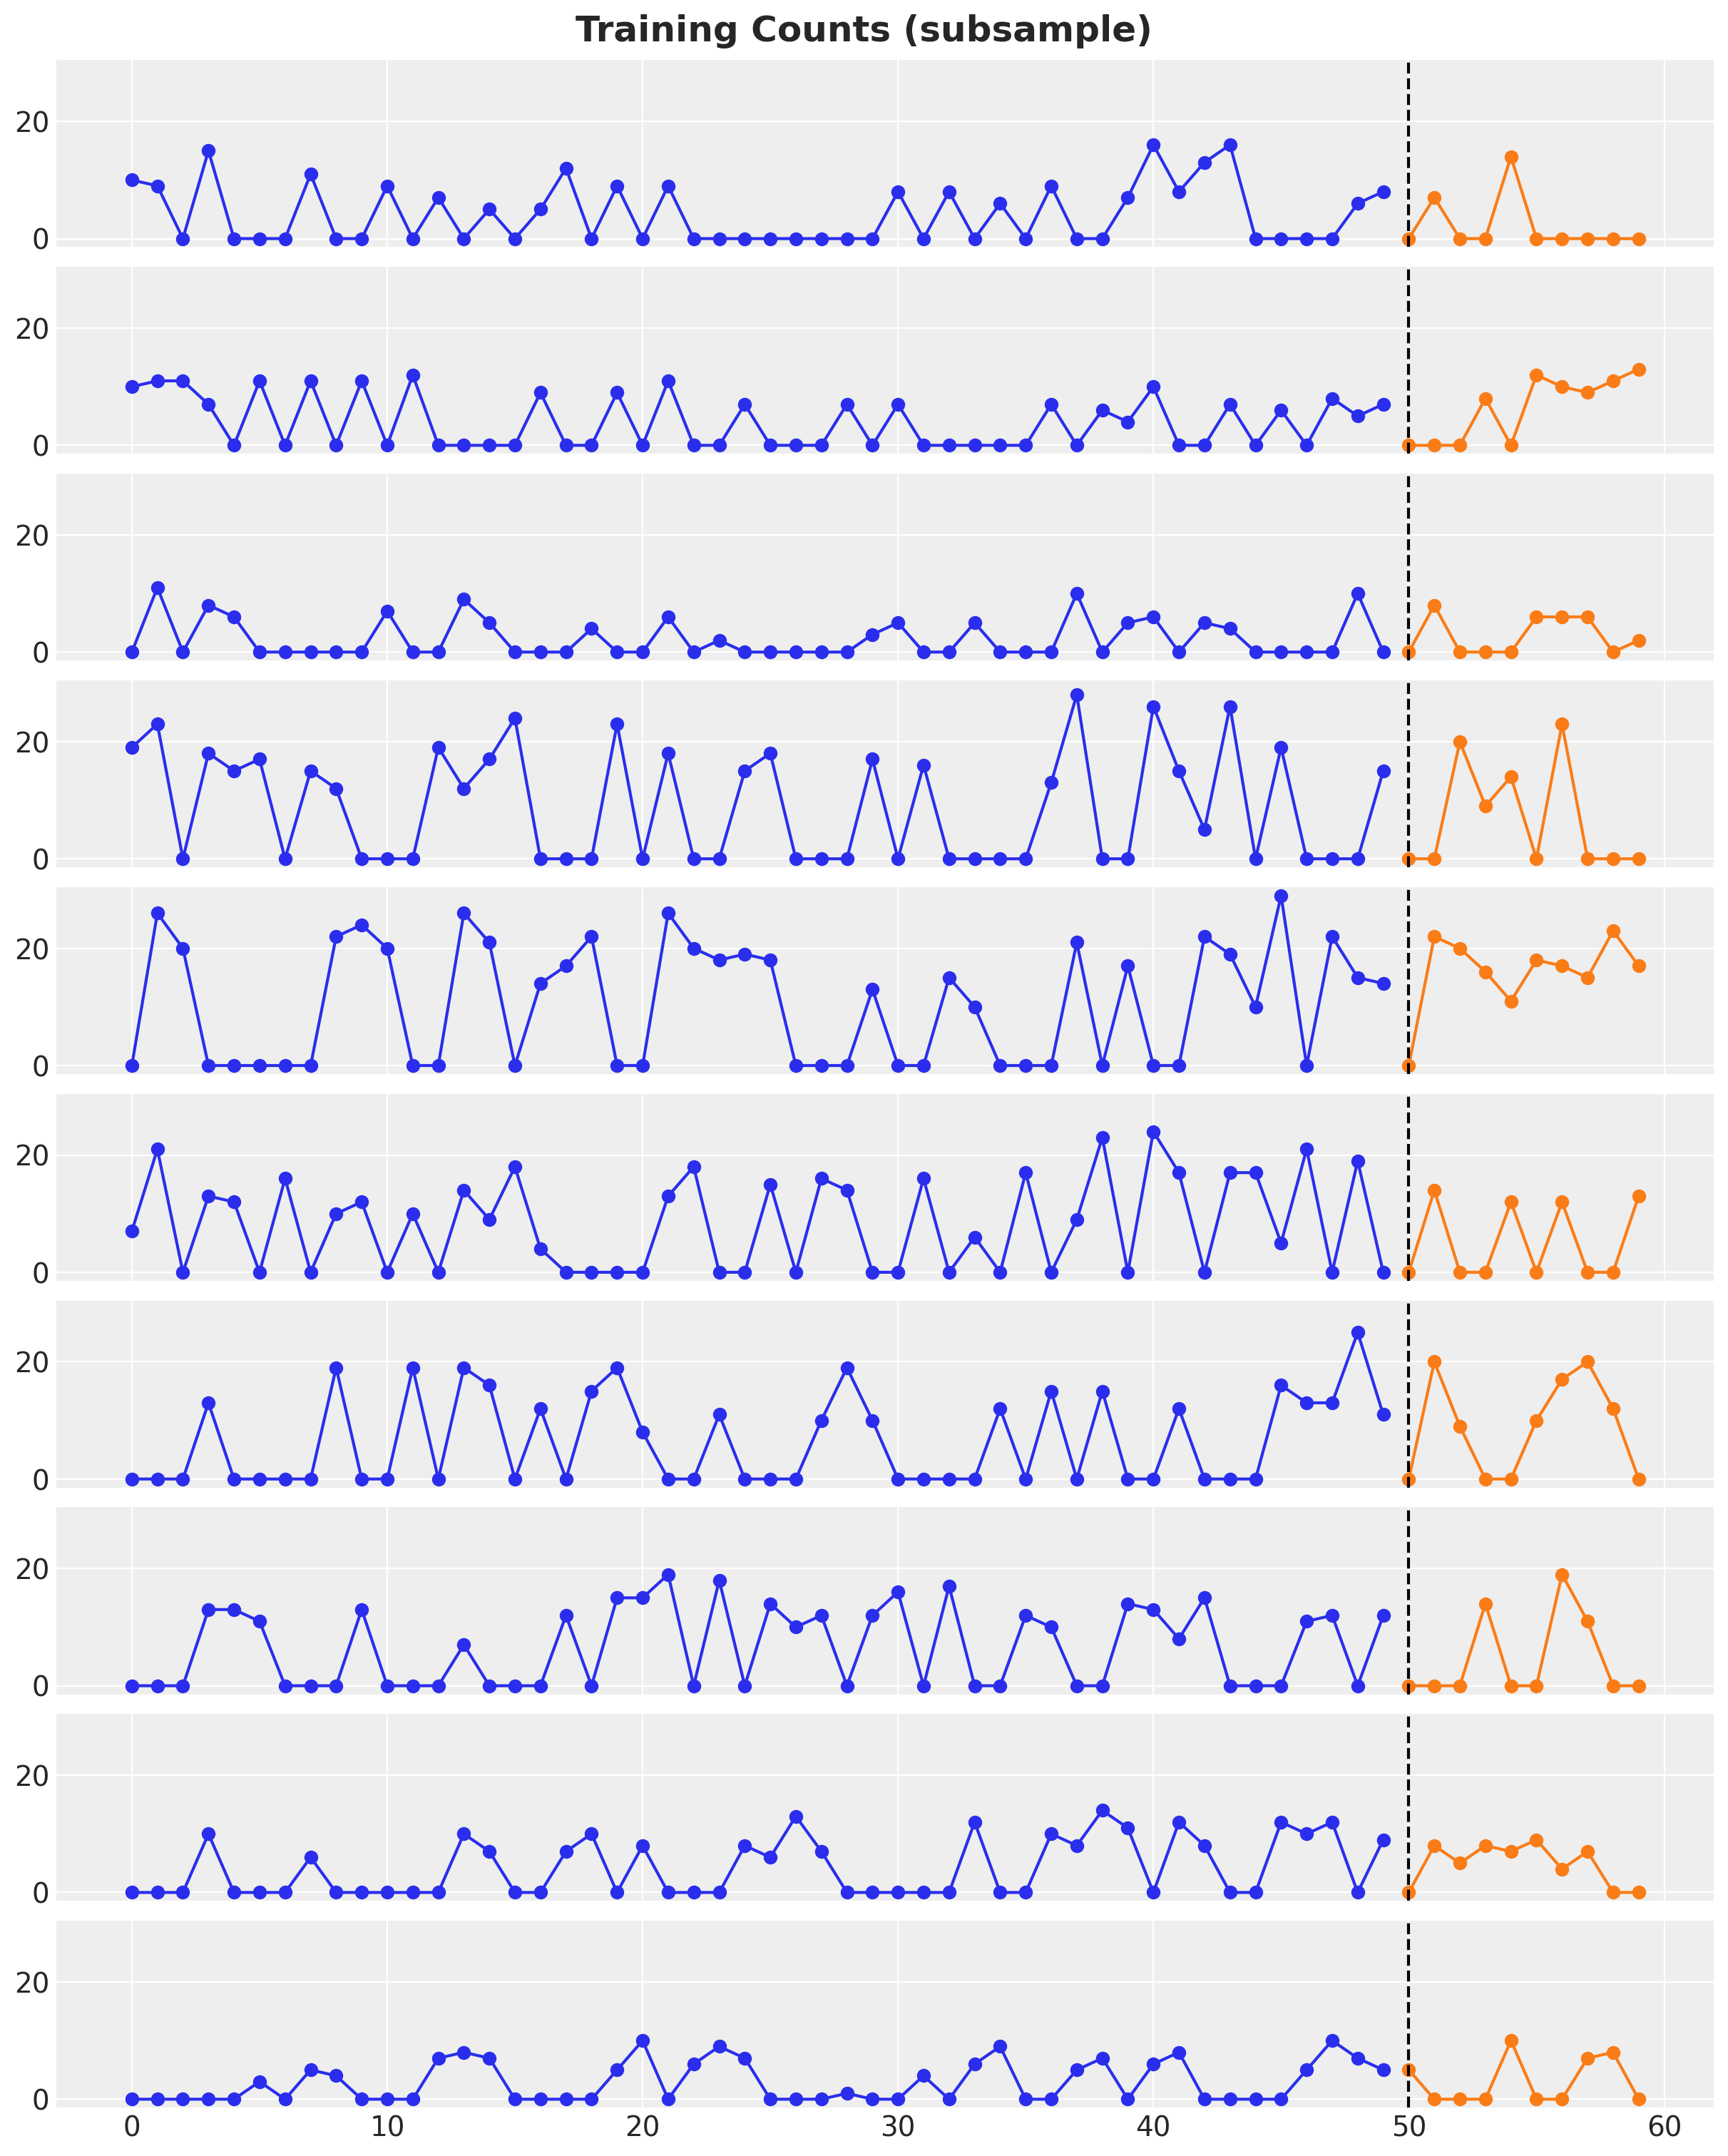

In [6]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax[i].plot(
        model_data_train.t, model_data_train.counts[:, i], marker="o", color="C0"
    )
    ax[i].plot(model_data_test.t, model_data_test.counts[:, i], marker="o", color="C1")
    ax[i].axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")

fig.suptitle("Training Counts (subsample)", fontsize=18, fontweight="bold");

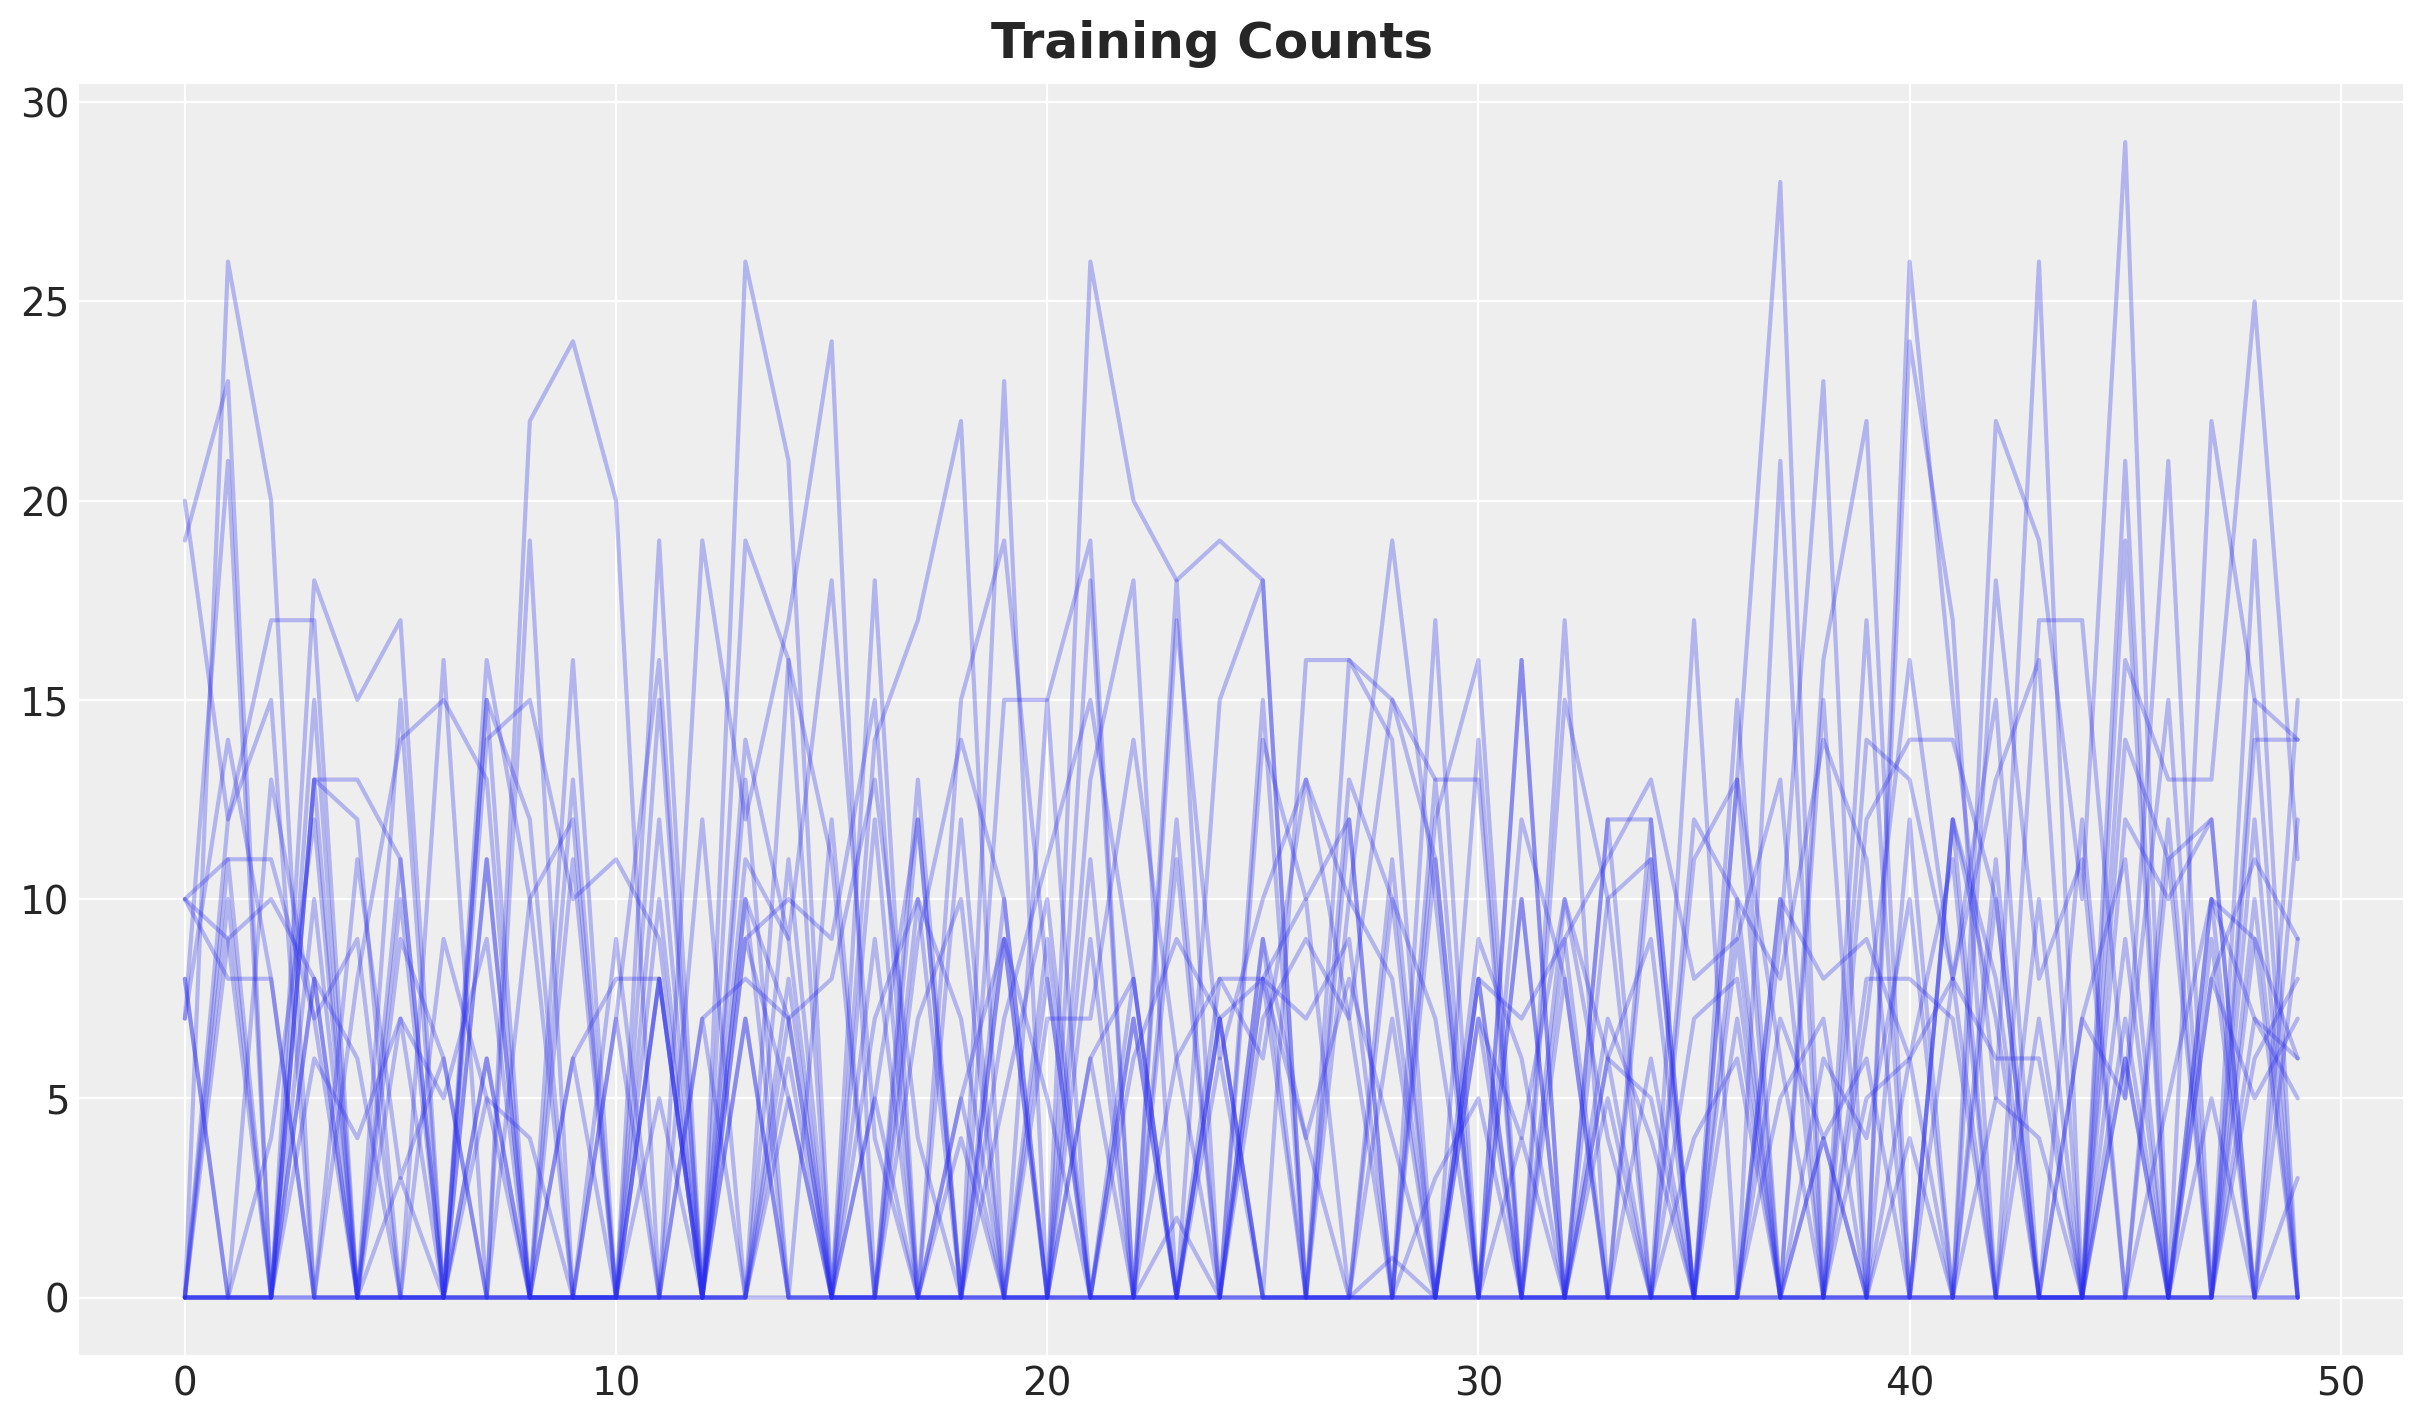

In [7]:
fig, ax = plt.subplots()
ax.plot(model_data_train.t, model_data_train.counts, c="C0", alpha=0.3)
fig.suptitle("Training Counts", fontsize=18, fontweight="bold");

In [8]:
def model(
    counts: Float32[Array, "t_max n_series"],
    # available: Float32[Array, "t_max_future n_series"],
    future: int = 0,
) -> None | Float32[Array, "future n_series"]:
    t_max, n_series = counts.shape

    noise_scale = numpyro.sample(
        "noise_scale", dist.LogNormal(loc=jnp.log(10), scale=0.3)
    )

    with numpyro.plate("n_series", n_series):
        z_smoothing = numpyro.sample(
            "z_smoothing",
            dist.Beta(concentration1=10, concentration0=40),
        )

        p_smoothing = numpyro.sample(
            "p_smoothing",
            dist.Beta(concentration1=10, concentration0=40),
        )

        noise = numpyro.sample("noise", dist.HalfNormal(scale=noise_scale))

    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max,
            jnp.where(
                counts[t] > 0,
                z_smoothing * counts[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max,
            jnp.where(
                counts[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - p_smoothing) * p_prev,
            ),
            p_prev,
        )

        mu = z_next * p_next

        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return (z_next, p_next), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": counts}):
        _, preds = scan(
            transition_fn,
            (counts[0], 0.5 * jnp.ones_like(counts[0])),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("forecast", preds[-future:, :])
    return None

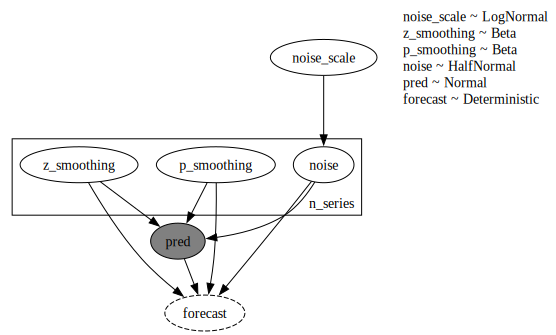

In [9]:
numpyro.render_model(
    model=model,
    model_kwargs={"counts": model_data_train.counts, "future": 1},
    render_distributions=True,
    render_params=True,
)

100%|██████████| 10000/10000 [00:01<00:00, 5687.19it/s, init loss: 41265.2070, avg. loss [9501-10000]: 3019.6603]


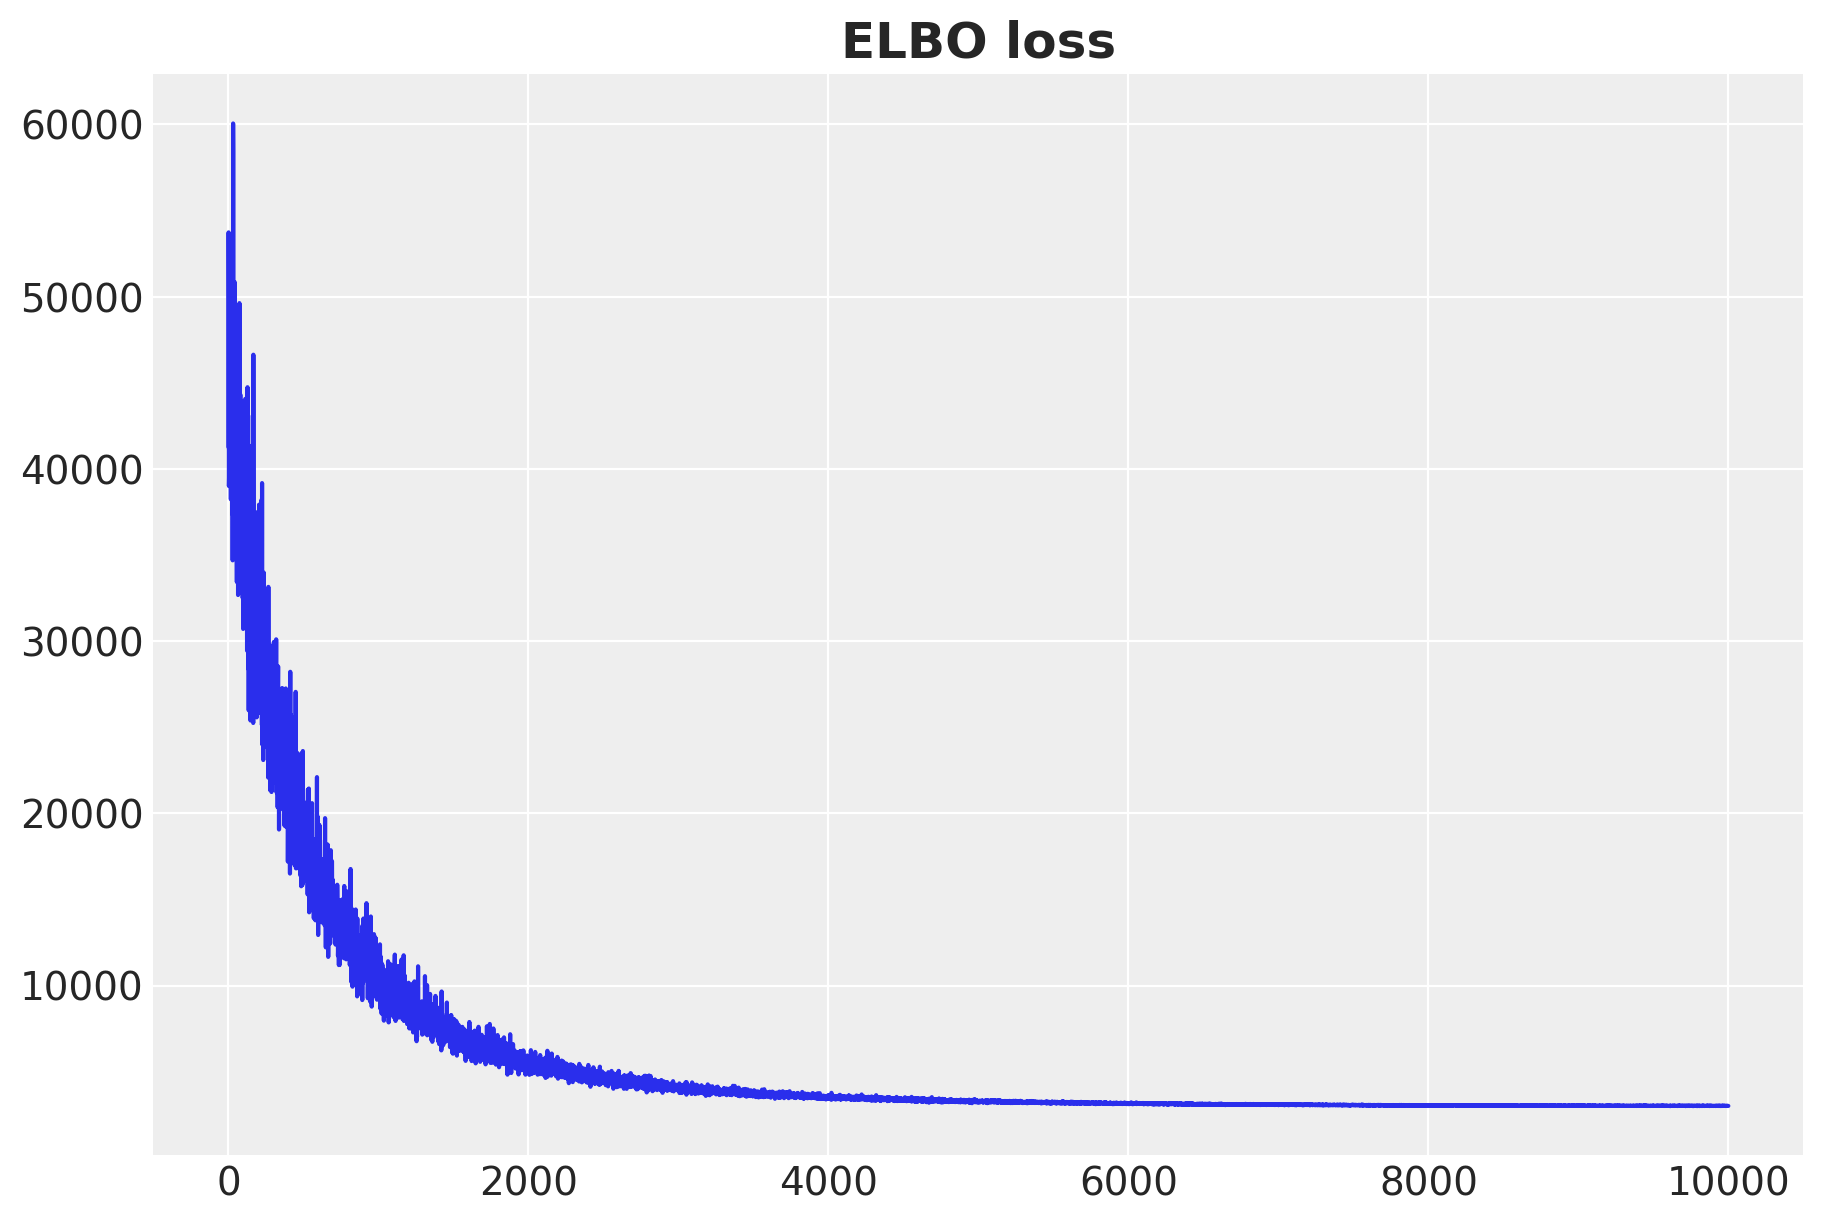

In [10]:
guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 10_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(rng_subkey, num_steps, model_data_train.counts)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
# ax.set_yscale("log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [11]:
posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=1_000,
    return_sites=["forecast"],
)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, model_data_train.counts, future=model_data_test.t.shape[0]
)

posterior_predictive_idata = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior_predictive_samples.items()
    },
    coords={"t_max": model_data_test.t, "n_series": series_ids},
    dims={"forecast": ["t_max", "n_series"]},
)

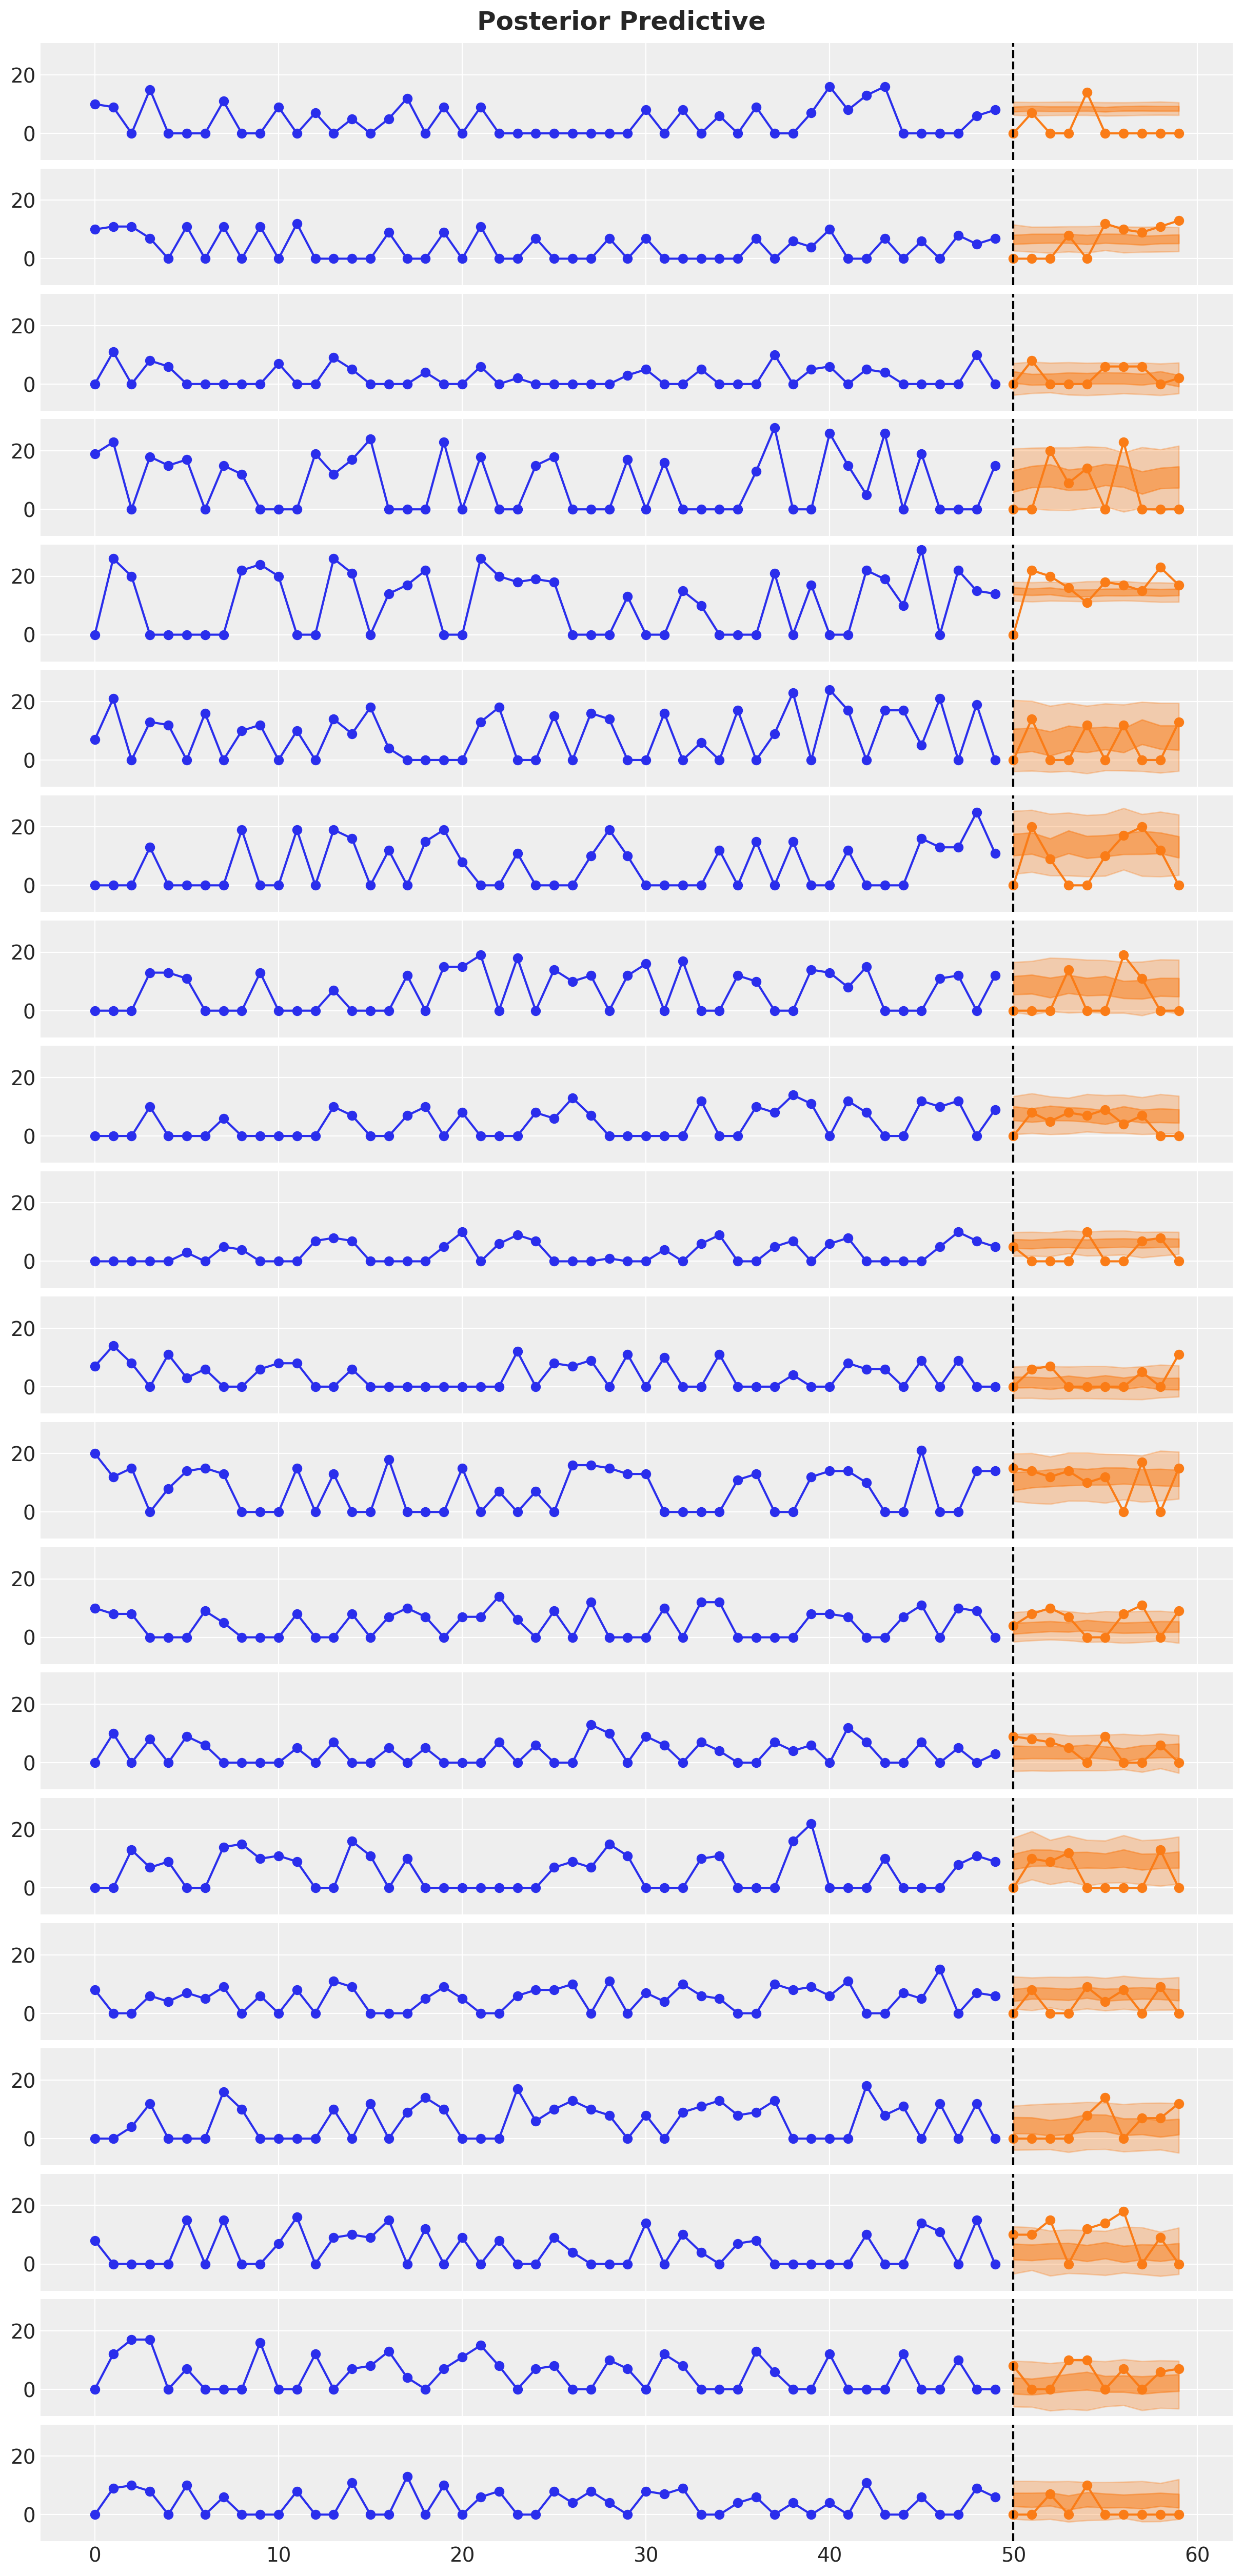

In [12]:
n_series_to_plot = 20

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in series_ids[:n_series_to_plot]:
    az.plot_hdi(
        model_data_test.t,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3},
        smooth=False,
        ax=ax[i],
    )
    az.plot_hdi(
        model_data_test.t,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax[i],
    )

    ax[i].plot(
        model_data_train.t, model_data_train.counts[:, i], marker="o", color="C0"
    )
    ax[i].plot(model_data_test.t, model_data_test.counts[:, i], marker="o", color="C1")
    ax[i].axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")

fig.suptitle("Posterior Predictive", fontsize=18, fontweight="bold");

In [13]:
def time_slice_cross_validation(
    rng_key: UInt32[Array, "2"],
    y: Float32[Array, "t_max n_series"],
    n_splits: int = 5,
) -> xr.Dataset:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        # Prepare data
        y_train = y[: -(n_splits - i), :]

        # Inference
        guide = AutoNormal(model)
        optimizer = numpyro.optim.Adam(step_size=0.001)
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
        num_steps = 10_000

        rng_key, rng_subkey = random.split(key=rng_key)
        svi_result = svi.run(rng_subkey, num_steps, y_train)

        # Forecast
        rng_key, rng_subkey = random.split(rng_key)
        posterior_predictive = Predictive(
            model=model,
            guide=guide,
            params=svi_result.params,
            num_samples=1_000,
            return_sites=["forecast"],
        )

        rng_key, rng_subkey = random.split(rng_key)
        posterior_predictive_samples = posterior_predictive(
            rng_subkey, y_train, future=1
        )

        posterior_predictive_idata = az.from_dict(
            posterior_predictive={
                k: v[None, ...] for k, v in posterior_predictive_samples.items()
            },
            coords={"t_max": [y_train.shape[0]], "n_series": series_ids},
            dims={"forecast": ["t_max", "n_series"]},
        )

        forecast_list.append(posterior_predictive_idata)

    # Concatenate forecasts
    return xr.concat(
        [x["posterior_predictive"] for x in forecast_list],
        dim=("t_max"),
    )

In [14]:
rng_key, rng_subkey = random.split(rng_key)
forecast_cv = time_slice_cross_validation(
    rng_subkey, model_data.counts, n_splits=model_data_test.t.shape[0]
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 5951.97it/s, init loss: 8575.0645, avg. loss [9501-10000]: 3441.7417]


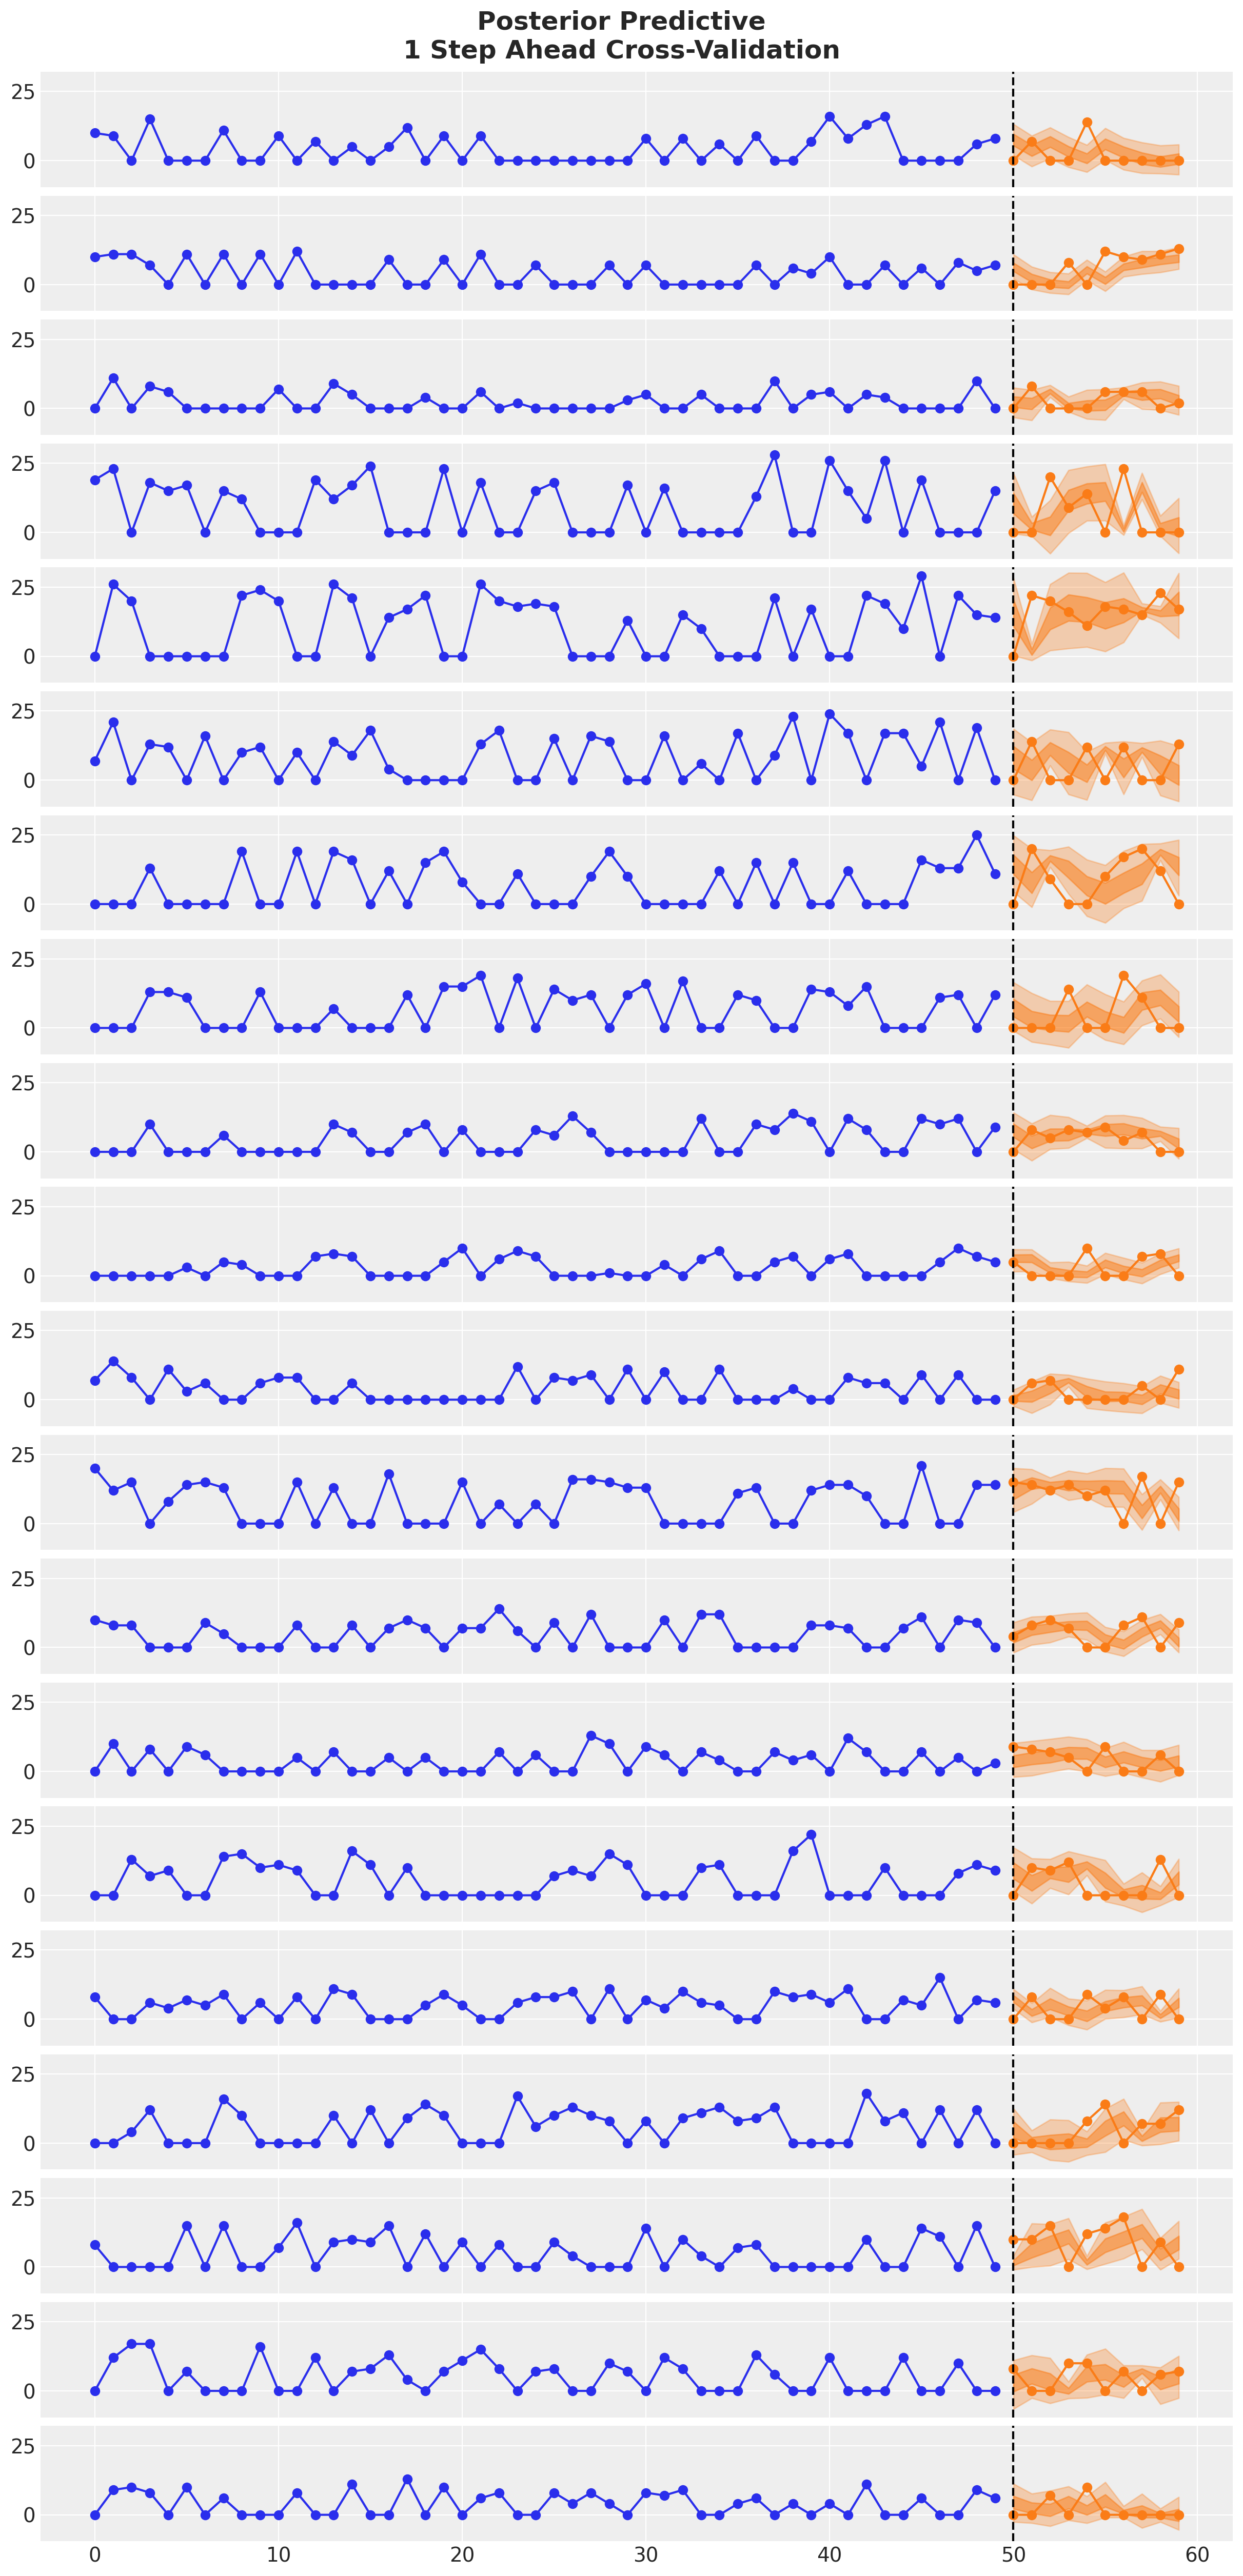

In [15]:
n_series_to_plot = 20

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in series_ids[:n_series_to_plot]:
    az.plot_hdi(
        model_data_test.t,
        forecast_cv.sel(n_series=i)["forecast"],
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3},
        smooth=False,
        ax=ax[i],
    )
    az.plot_hdi(
        model_data_test.t,
        forecast_cv.sel(n_series=i)["forecast"],
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax[i],
    )

    ax[i].plot(
        model_data_train.t, model_data_train.counts[:, i], marker="o", color="C0"
    )
    ax[i].plot(model_data_test.t, model_data_test.counts[:, i], marker="o", color="C1")
    ax[i].axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")

fig.suptitle(
    "Posterior Predictive\n1 Step Ahead Cross-Validation",
    fontsize=18,
    fontweight="bold",
);